In [ ]:
import datetime
import os
import tempfile
import time

import numpy as np
import pvporcupine
import pyttsx3
import scipy.io.wavfile
import sounddevice as sd
import webrtcvad
import whisper
from pvrecorder import PvRecorder

In [5]:
for i, device in enumerate(PvRecorder.get_available_devices()):
    print('Device %d: %s' % (i, device))

Device 0: NHK訪問営業部2 Microphone
Device 1: USB PnP Sound Device
Device 2: MacBook Pro Microphone
Device 3: Microsoft Teams Audio


In [6]:
whisper.available_models()

['tiny.en',
 'tiny',
 'base.en',
 'base',
 'small.en',
 'small',
 'medium.en',
 'medium',
 'large-v1',
 'large-v2',
 'large-v3',
 'large',
 'large-v3-turbo',
 'turbo']

In [17]:
pvporcupine.KEYWORDS

{'alexa',
 'americano',
 'blueberry',
 'bumblebee',
 'computer',
 'grapefruit',
 'grasshopper',
 'hey barista',
 'hey google',
 'hey siri',
 'jarvis',
 'ok google',
 'pico clock',
 'picovoice',
 'porcupine',
 'terminator'}

# Wake Word Detection

In [ ]:
keywords = ["computer", "bumblebee"]

porcupine = pvporcupine.create(
    access_key=os.getenv("PORCUPINE_ACCESS_KEY"),
    # Won't work on macOS, only Raspberry Pi
    # keyword_paths=["~/Downloads/Hey-Palm-Tree_en_raspberry-pi_v3_0_0/Hey-Palm-Tree_en_raspberry-pi_v3_0_0.ppn"],
    keywords=keywords,
)

recorder = PvRecorder(frame_length=porcupine.frame_length, device_index=1)
recorder.start()

print("Listening ... (press Ctrl+C to exit)")

try:
    while True:
        pcm = recorder.read()
        result = porcupine.process(pcm)
        if result >= 0:
            print("[%s] Detected %s" % (str(datetime.datetime.now()), keywords[result]))
except KeyboardInterrupt:
    print("Stopping ...")
finally:
    recorder.delete()
    porcupine.delete()

# Voice Activity Detection (VAD) and Audio Transcription

In [18]:
SAMPLE_RATE = 16000
FRAME_DURATION_MS = 30
FRAME_SIZE = int(SAMPLE_RATE * FRAME_DURATION_MS / 1000)  # samples per frame
SILENCE_TIMEOUT = 2.0  # seconds of silence to trigger stop
VAD_MODE = 2  # 0-3: more aggressive = more sensitive to voice


def record_audio():
    vad = webrtcvad.Vad(VAD_MODE)

    recording = False
    silence_start = None

    stream = sd.InputStream(
        samplerate=SAMPLE_RATE,
        channels=1,
        dtype="int16",
        blocksize=FRAME_SIZE,
        device=1,
    )
    stream.start()

    audio_data = []

    try:
        while True:
            block, _ = stream.read(FRAME_SIZE)
            samples = block[:, 0].tobytes()

            is_speech = vad.is_speech(samples, SAMPLE_RATE)

            if is_speech:
                if not recording:
                    print("🧠 Detected speech. Recording...")
                    recording = True
                silence_start = None
                audio_data.append(samples)
            elif recording:
                if silence_start is None:
                    silence_start = time.time()
                elif time.time() - silence_start > SILENCE_TIMEOUT:
                    print("🤫 Silence detected. Stopping recording.")
                    break

    finally:
        stream.stop()

    return b"".join(audio_data)


whisper_model = whisper.load_model("base")


def transcribe_audio(audio_bytes) -> str:
    """
    Transcribe audio bytes using Whisper.
    """
    audio_array = np.frombuffer(audio_bytes, dtype=np.int16)
    with tempfile.NamedTemporaryFile(suffix=".wav") as tmpfile:
        scipy.io.wavfile.write(tmpfile.name, SAMPLE_RATE, audio_array)
        result = whisper_model.transcribe(tmpfile.name)
        return result["text"]


def speak_text(text):
    tts = pyttsx3.init()
    tts.say(text)
    tts.runAndWait()
    tts.stop()


# print("🎙️ PALM‑9000 is listening for your message...")

# # Get voice input
# audio_bytes = record_audio()

# # Transcribe with Whisper
# text = transcribe_audio(audio_bytes)

# # Print and speak the result
# speak_text(text)

# Putting it All Together

In [16]:
keywords = ["computer", "bumblebee"]

porcupine = pvporcupine.create(
    access_key=os.getenv("PORCUPINE_ACCESS_KEY"),
    # Won't work on macOS, only Raspberry Pi
    # keyword_paths=["~/Downloads/Hey-Palm-Tree_en_raspberry-pi_v3_0_0/Hey-Palm-Tree_en_raspberry-pi_v3_0_0.ppn"],
    keywords=keywords,
)


def on_wake_word():
    print("Wake word detected.")

    audio_bytes = record_audio()

    text = transcribe_audio(audio_bytes)

    print("User said:", text)

    # Get LLM response
    # response = palm_9000_llm.invoke([HumanMessage(content=text)])

    # Speak
    speak_text(text)


recorder = PvRecorder(frame_length=porcupine.frame_length, device_index=1)
recorder.start()

print("Listening ... (press Ctrl+C to exit)")

try:
    while True:
        pcm = recorder.read()
        result = porcupine.process(pcm)
        if result >= 0:
            print("[%s] Detected %s" % (str(datetime.datetime.now()), keywords[result]))
            on_wake_word()
except KeyboardInterrupt:
    print("Stopping ...")
finally:
    recorder.delete()
    porcupine.delete()

Listening ... (press Ctrl+C to exit)
[2025-07-01 18:09:32.824803] Detected computer
Wake word detected.
🧠 Detected speech. Recording...
🤫 Silence detected. Stopping recording.


/Users/hankehly/Projects/PALM-9000/.venv/lib/python3.12/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


User said:  A, B, C, D, E, F, G.
Stopping ...


In [2]:
import sounddevice as sd
sd.query_devices()

  0 NHK訪問営業部2 Microphone, Core Audio (1 in, 0 out)
> 1 MacBook Pro Microphone, Core Audio (1 in, 0 out)
< 2 MacBook Pro Speakers, Core Audio (0 in, 2 out)
  3 Microsoft Teams Audio, Core Audio (2 in, 2 out)
  4 BlackHole/Speakers, Core Audio (0 in, 2 out)

In [ ]:
import math

import numpy as np

seconds = 2
num_frames = 44100 * seconds
num_loops = math.ceil(num_frames / 1024)
current_loop = 0

result = np.zeros((num_frames, 1), dtype=np.int16)  # Preallocate array for audio data

with sd.InputStream(
    samplerate=44100,  # 44100 samples per second
    channels=1,        # Mono audio
    dtype="int16",     # Bit-depth of the audio samples (each sample will be a value between -32768 and 32767)
    blocksize=1024,    # Number of frames to read at once (a frame is a single sample for each channel)
    device=1,
) as stream:
    print("Listening for audio input...")
    while current_loop < num_loops:
        block, _ = stream.read(1024)  # block is (frames, channels) shape, so in our case (1024, 1)
        result[current_loop * 1024:(current_loop + 1) * 1024] = block  # Store only the first channel
        current_loop += 1

Listening for audio input...


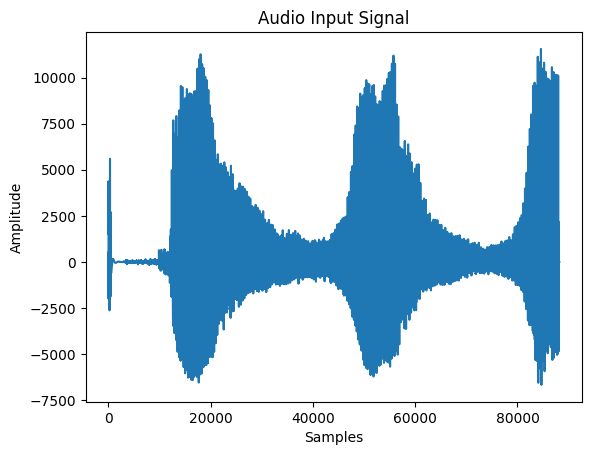

In [4]:
# plot result
import matplotlib.pyplot as plt

plt.plot(result)
plt.title("Audio Input Signal")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()